In [29]:
import torch
from time import time

a = torch.ones(1000)
b = torch.ones(1000)

In [30]:
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]

print(time()- start)

0.009912252426147461


In [31]:
start = time()
d = a+b
print(time() - start) # 使用矢量运算更加省时

0.0010046958923339844


In [32]:
a = torch.ones(3)
b = 10
print(a+b)

tensor([11., 11., 11.])


# 实现线性回归 复杂

In [33]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [34]:
# 生成数据
num_inputs = 2
num_examples = 10000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,dtype=torch.float32)
labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32)
print(features[0], labels[0])

tensor([ 1.7478, -0.4615]) tensor(9.2693)


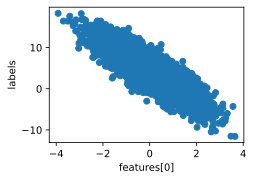

In [35]:
plt.xlabel('features[0]')
plt.ylabel('labels')
plt.scatter(features[:,1], labels)

## 读取数据

In [36]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j), labels.index_select(0,j)


In [37]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X,y)
    break

tensor([[-0.9487, -0.4668],
        [-0.0044, -0.8525],
        [-1.1147,  0.3693],
        [ 0.5653,  0.4472],
        [-0.2102,  0.7607],
        [ 1.0142,  1.1488],
        [ 0.6829,  0.5164],
        [ 0.6488,  0.5262],
        [ 2.3845,  1.7287],
        [-0.4975,  0.0325]]) tensor([3.9049, 7.0832, 0.7020, 3.8112, 1.1835, 2.3370, 3.7901, 3.7272, 3.0944,
        3.1046])


In [38]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype = torch.float32)
w.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)


tensor([0.], requires_grad=True)

In [39]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

In [40]:
def loss(y_hat, y):
    return (y_hat - y.view(y_hat.size()))**2 /2

In [44]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad / batch_size

In [45]:
lr = 0.03
num_epochs = 3
net = linreg
loss = loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [46]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0003],
        [-3.3991]], requires_grad=True)
4.2 
 tensor([4.2000], requires_grad=True)


# 实现线性回归 简单

### 优化算法、数据集、损失函数、net forward函数

In [47]:
# 生成数据
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)


In [50]:
# 读取数据
import torch.utils.data as Data
batch_size = 10

dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [52]:
import torch.nn as nn
# 定义模型
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net) # 使用print可以打印出网络的结构

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [54]:
net = nn.Sequential(
    nn.Linear(num_inputs,1)
)
net


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [56]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.4592, -0.4003]], requires_grad=True)
Parameter containing:
tensor([-0.4995], requires_grad=True)


In [57]:
# 初始化模型参数

from torch.nn import init
init.normal_(net[0].weight, mean = 0,std=0.01)
init.constant_(net[0].bias, val = 0)

In [61]:
# 定义损失函数
loss = nn.MSELoss()


In [62]:
# 定义优化算法
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [63]:
# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))


epoch 1, loss: 0.000109
epoch 2, loss: 0.000066
epoch 3, loss: 0.000051


In [64]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0003, -3.3995]], requires_grad=True)
4.2 Parameter containing:
tensor([4.2003], requires_grad=True)
